# Rutina en Python para comparación de una estimación vía kriging ordinario versus una RNA

En este cuaderno de Jupyter se implementará un modelo de RNA, el cual buscará predecir el valor que toma una variable numérica continua y al mismo tiempo comparar dichos resultados con las del método geoestadístico kriging ordinario. Finalmente, se analizará si es que la RNA se acerca a los resultados de KO.  

Principales pasos: 

1.	A través de la simulación secuencial gaussiana se creará un escenario exhaustivo para una variable llamada “VA”. 
2.	Se extraerá una muestra aleatoria de dicha variable, equivalente al 4% de la población. 
3.	Se utilizará el modelo variograma real para estimar con Kriging Ordinario en una malla igual a las dimensiones de la simulación. 
4.	Se entrenará una RNA que prediga el valor de la variable “VA” en la malla.
5.	Se compararán los resultados de la RNA vs KO. 
 


In [1]:
import geostatspy.GSLIB as GSLIB                          # Utilidades GSLIB y funciones envueltas
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import os                                                 # Para configurar el directorio de trabajo
import numpy as np                                        # Biblioteca de funciones matemáticas
import pandas as pd                                       # Biblioteca para manipulación de marcos de datos
import matplotlib.pyplot as plt                           # Biblioteca para salida gráfica
import scipy.stats                                        # Biblioteca de resumenes estadísticos y matemáticos
import random as rand
#NOTA: En base se avance con el codigo, se iran incorporando nuevas bibliotecas.

In [2]:
os.chdir("GSLIB_FOLDER") # ruta de ejecutables de GSLIB

In [3]:
import os
print(os.getcwd())

c:\Users\nicoi\Desktop\Nube minera RNA\6- Implementacion\GSLIB_FOLDER


**1. Creación del escenario simulado 2D**

In [4]:
# Parámetros de modelado, la malla del modelo, la semilla aleatoria, la distribución objetivo y la barra de colores
nx = 200; ny = 200; cell_size = 10       # número de celdas duplicado (doble resolución)

xmin = 0; ymin = 0                       # origen grilla

xmax = 2000; ymax = 2000                 # dimensiones máximas duplicadas

seed = 172763650                         # semilla aleatoria (igual para mantener reproducibilidad)

vmin = 0; vmax = 1; cmap = plt.cm.jet    # escala de color


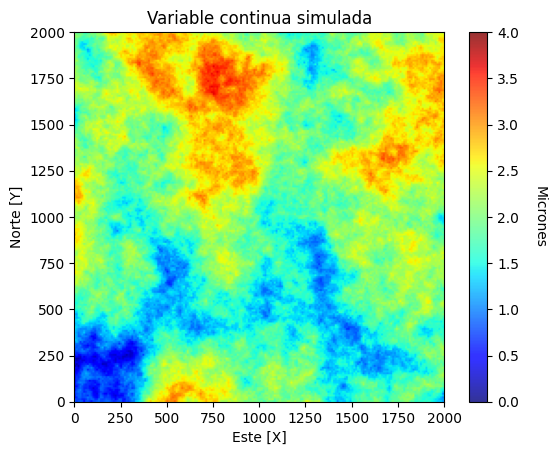

In [5]:
# Crear un modelo real / simulación incondicional con modelo duplicado
va_mean = 2
va_stdev = 0.55
va_cmin = 0
va_cmax = 4

# Definir el variograma igual (no cambia por tamaño de grilla)
var = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1, azi1=135, hmaj1=1000, hmin1=1000)

# Nuevos parámetros de malla 
nx = 200; ny = 200; cell_size = 10
xmin = 0; ymin = 0
xmax = 2000; ymax = 2000
seed = 17276

# Simulación incondicional
VA = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, var, "u")

# Ajustar media y desviación estándar
VA = GSLIB.affine(VA, va_mean, va_stdev)

# Graficar con los nuevos límites
GSLIB.pixelplt_st(VA, xmin, xmax, ymin, ymax, cell_size, va_cmin, va_cmax,
                  "Variable continua simulada", "Este [X]", "Norte [Y]", "Micrones", cmap)
plt.show()


se hace el dataframe con la info

In [6]:
#Se crea el dataframe
df_zko = pd.DataFrame(VA)
df11 = df_zko.stack().reset_index().rename(columns={"level_0": "Norte[Y]", "level_1": "Este[X]", 0:"VA"})

x = df11["Norte[Y]"].iloc[::-1].reset_index()

df11["Norte[Y]"] = x["Norte[Y]"]

##############################################################################################################
grid_x = np.linspace(0, nx * cell_size, num=nx, endpoint=False)
grid_y = np.linspace(0, ny * cell_size, num=ny, endpoint=False)


gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 

yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)

x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg

d = {'Este[X]': x_g, 'Norte[Y]': y_g} #Columnas con coordenadas X e Y.
df = pd.DataFrame(data=d) #Creación del dataframe 

h = df["Norte[Y]"].iloc[::-1].reset_index()

df["Norte[Y]"] = h["Norte[Y]"]

df["VA"] = df11["VA"] #Traspaso de la columna VA al nuevo DataFrame.
df.head()

,Este[X],Norte[Y],VA
0,0.0,1990.0,1.899341
1,10.0,1990.0,1.866567
2,20.0,1990.0,1.865535
3,30.0,1990.0,1.922505
4,40.0,1990.0,1.943104


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Este[X],40000.0,995.0,577.350269,0.000000,497.500000,995.000000,1492.500000,1990.000000
Norte[Y],40000.0,995.0,577.350269,0.000000,497.500000,995.000000,1492.500000,1990.000000
VA,40000.0,2.0,0.550007,0.122759,1.643708,1.993066,2.366111,3.635361


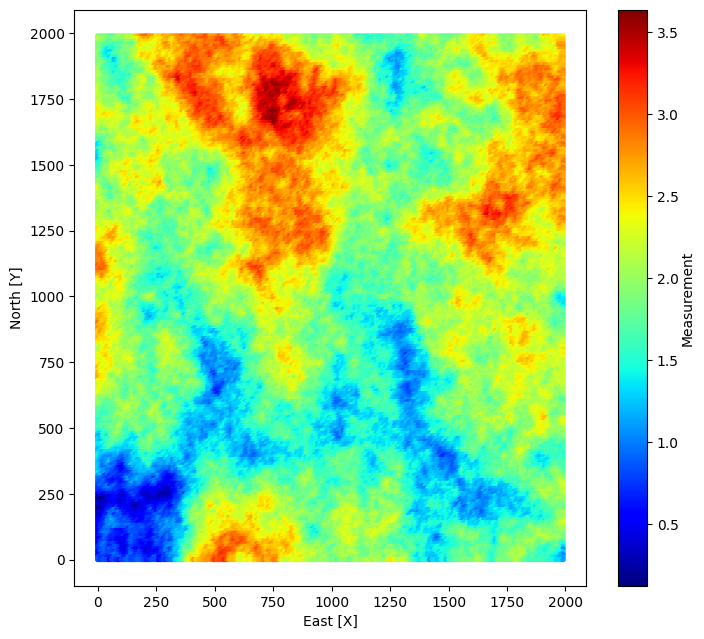

In [8]:
marker_size=8
plt.subplot(111)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA"], cmap = plt.cm.jet)
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.title('')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.subplots_adjust(left=0, bottom=0.0, right=1, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

**2. Extracción muestra:**

In [9]:
# Mantener distancia de muestreo constante para igual densidad
mx = 20; my = 20

sample_data1 = GSLIB.regular_sample(VA, xmin, xmax, ymin, ymax, cell_size, mx, my, nx, ny, "VA")

nsamp_random = 380 * 4  # por área 2x2 = 4x

sample_data2 = GSLIB.random_sample(VA, xmin, xmax, ymin, ymax, cell_size, nsamp_random, 'VA')

sample_data = pd.concat([sample_data1, sample_data2], ignore_index=True)


In [10]:
print(f"Puntos regulares: {len(sample_data1)}")
print(f"Puntos aleatorios: {len(sample_data2)}")
print(f"Total: {len(sample_data)}")


Puntos regulares: 81
Puntos aleatorios: 1520
Total: 1601


In [11]:
print((sample_data["VA"].count() * 100/df11["VA"].count()), "% es el tamaño de la muestra")

4.0025 % es el tamaño de la muestra


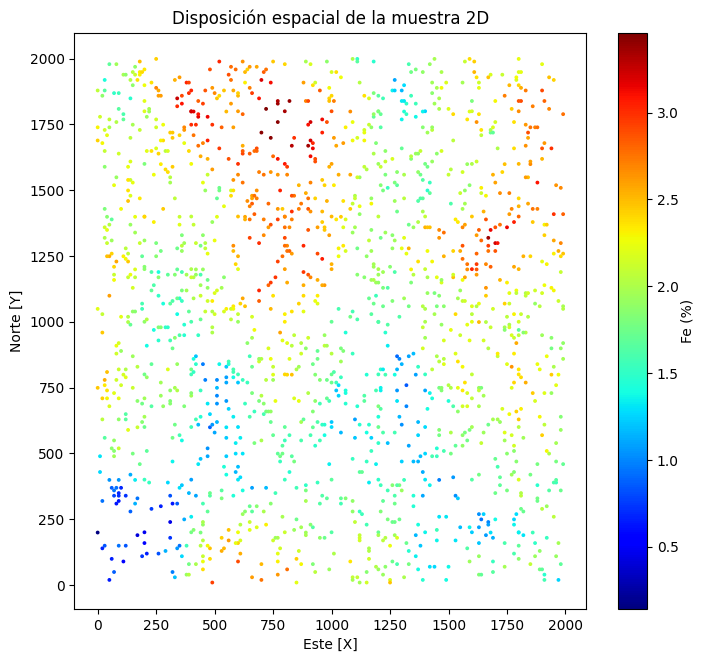

In [12]:
marker_size=3
plt.subplot(111)
plt.scatter(sample_data["X"], sample_data["Y"], marker_size, sample_data["VA"], cmap = plt.cm.jet)
plt.xlabel('Este [X]')
plt.ylabel('Norte [Y]')
plt.title('Disposición espacial de la muestra 2D')
plt.grid(False)
cbar=plt.colorbar()
#plt.clim(-4,4)

cbar.set_label('Fe (%)', labelpad=+1)
#plt.savefig("C:/Users/nubem/Desktop/EJERCICIOS_RESUELTOS_GEOESTADÍSTICA/dataset_2d_regular_aniso.png", dpi=300)
plt.subplots_adjust(left=0, bottom=0.0, right=1, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [13]:
sample_data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,1601.0,1006.608370,571.755238,0.00000,530.000000,990.000000,1510.000000,1990.000000
Y,1601.0,1014.634603,575.666261,9.00000,509.000000,1019.000000,1499.000000,1999.000000
VA,1601.0,2.009596,0.553424,0.16564,1.643732,1.990155,2.353032,3.491876


**3. Estimación Kriging Ordinario:**

In [14]:
# Kriging
vario_kri = GSLIB.make_variogram(nug=0.0, nst=1, it1=1, cc1=1.0, azi1=90, hmaj1=1000, hmin1=1000)

nx = 200; ny = 200
xsiz = 10; ysiz = 10
xmn = 0; ymn = 0
ndmax = 20; ndmin = 1
radius = 1000  

ktype = 1
skmean = 0
nxdis = 1; nydis = 1
tmin = -9999; tmax = 9999

kmap, vmap = geostats.kb2d(sample_data, "X", "Y", "VA", tmin, tmax,
                           nx, xmn, xsiz, ny, ymn, ysiz,
                           nxdis, nydis, ndmin, ndmax, radius, ktype, skmean, vario_kri)

100%|██████████| 200/200 [01:01<00:00,  3.23it/s]

  Estimated   40000 blocks 
      average   1.9935664009352534  variance  0.28935034232726053


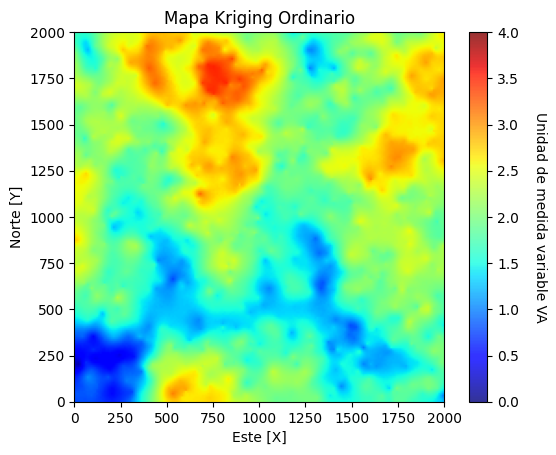

In [15]:
GSLIB.pixelplt_st(kmap, xmin, xmax, ymin, ymax, 1, 0, 4,
                  "Mapa Kriging Ordinario", 
                  "Este [X]", 
                  "Norte [Y]", 
                  "Unidad de medida variable VA", 
                  cmap)


In [16]:
df_kmap = pd.DataFrame(kmap) #se pasan los valores estimados al dataframe de la simulación 
df_kmap = df_kmap.stack().reset_index().rename(columns={"level_0": "Norte[Y]", "level_1": "Este[X]", 0:"VA"})

df["VA_KO"]= df_kmap["VA"]
df.head()

,Este[X],Norte[Y],VA,VA_KO
0,0.0,1990.0,1.899341,1.702757
1,10.0,1990.0,1.866567,1.675766
2,20.0,1990.0,1.865535,1.651678
3,30.0,1990.0,1.922505,1.632538
4,40.0,1990.0,1.943104,1.620752


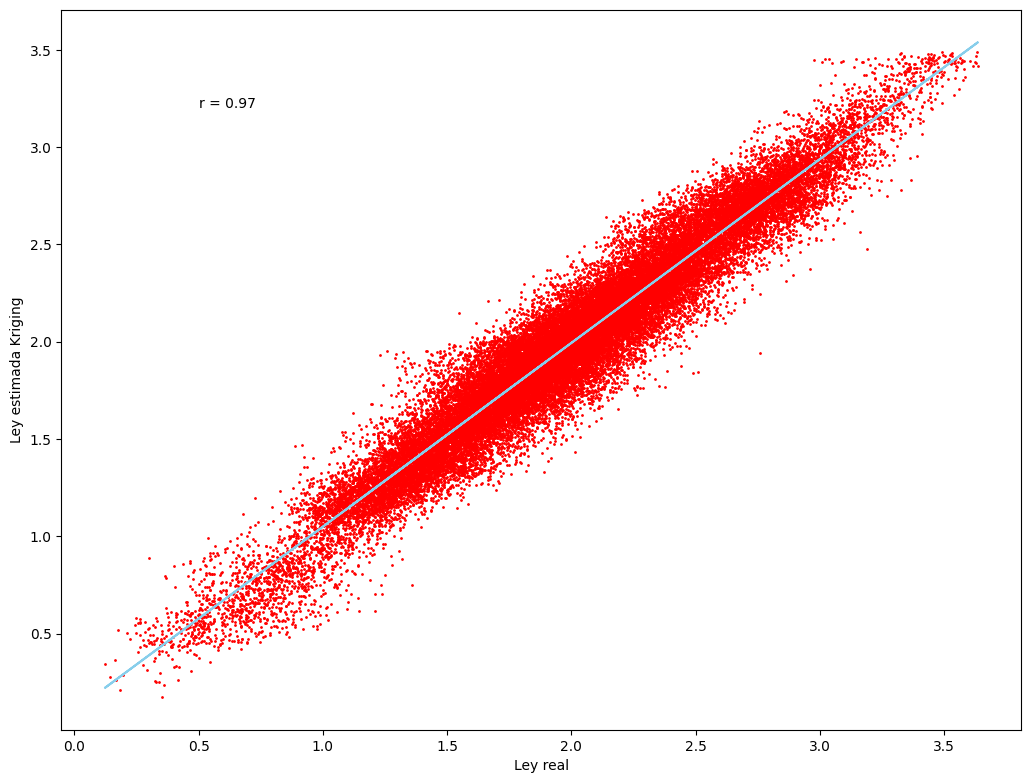

In [17]:
x = df["VA"] 
y = df["VA_KO"] 
#Calculando los coeficientes del ajuste de regresión:
a, b = np.polyfit(x, y, 1) # 1 es el grado del polinomio
r = np.corrcoef(x, y) # r = coeficiente de correlación
#print("R:", r, "a:", a, "b:", b) # b: pendiente de la recta, a: ordenada en la vertical (Y = bX + a)
plt.subplot(111)
plt.scatter(x,y, color="r", s=1)
plt.xlabel("Ley real")
plt.ylabel("Ley estimada Kriging")
plt.plot(x, a * x + b, color="skyblue")
plt.text(0.5,3.2, 'r = {0:2.2f}'.format(r[0,1]))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5)
plt.show()

Tiene una correlacion del 97%, extraemaamente alto debido a que usamos el variograma real, cuando en la realidad se estima y es la principal fuente de sesgo en el kriging


**4. Implementación RNA:**

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.optimizers import RMSprop 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Separamos en x e y las variables explicativas de la objetivo

In [147]:
X = sample_data.drop('VA',axis=1) 
X.head()
y = sample_data["VA"]
y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,random_state=17276)

In [69]:
y = sample_data["VA"]
y

0       2.182796
1       1.802630
2       2.406628
3       1.874829
4       1.881076
          ...   
1596    2.289797
1597    2.143468
1598    2.425178
1599    1.855152
1600    2.959870
Name: VA, Length: 1601, dtype: float64

Se separa el 10% de la muestra para no usarla en el entrenamiento para poder evaluar el modelo antes de predecir


In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,random_state=17276)

In [150]:
print(X_train.min(), X_train.max())


X    0.0
Y    9.0
dtype: float64 X    1990.0
Y    1999.0
dtype: float64


In [54]:
X_train.shape

(1440, 2)

In [55]:
X_test.shape

(161, 2)

Se entrena una grilla de modelos, con el fin de elegir los mejores hiperparametros. si queremos que no nos muestre las epocs y los datos de entrenamiento, poner verbose=0 en el ciclo for


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
tf.config.run_functions_eagerly(True)

# Datos
X = sample_data.drop('VA', axis=1)
y = sample_data['VA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=17276)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parámetros a evaluar
arquitecturas = [
    [36, 18], 
    [36, 18, 9], 
    [64, 32],  
    [16, 8]
]

opt_params = {
    'adam': lambda: Adam(learning_rate=0.001),
    'sgd': lambda: SGD(learning_rate=0.01),
    'rmsprop': lambda: RMSprop(learning_rate=0.001)
}

resultados = []
batch_sizes = [64]

for arch in arquitecturas:
    for opt_name, opt_fn in opt_params.items():
        for batch in batch_sizes:
            print(f"Probando: Arq={arch}, Opt={opt_name}, Batch={batch}")
            
            model = models.Sequential()
            model.add(layers.Input(shape=(2,)))
            for n in arch:
                model.add(layers.Dense(n, activation='relu'))
            model.add(layers.Dense(1))

            opt = opt_fn()  
            model.compile(optimizer=opt, loss='mean_squared_error')

            early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )

            history = model.fit(
                X_train_scaled, y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=500,
                batch_size=batch,
                callbacks=[early_stop],
                verbose=1
            )

            y_pred = model.predict(X_test_scaled).flatten()
            mse = mean_squared_error(y_test, y_pred)

            resultados.append({
                'arquitectura': arch,
                'optimizador': opt_name,
                'batch_size': batch,
                'mse': mse
            })


# Mostramos los resultados ordenados por performance
resultados_df = pd.DataFrame(resultados).sort_values(by='mse')
print(resultados_df.head(10))  # Top 10


Probando: Arq=[36, 18], Opt=adam, Batch=64
Epoch 1/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 3.9947 - val_loss: 2.5905
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 2.2165 - val_loss: 1.3470
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1.1765 - val_loss: 0.6645
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.6049 - val_loss: 0.3808
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.3883 - val_loss: 0.3455
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.3545 - val_loss: 0.3231
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.3391 - val_loss: 0.3017
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.3050 - val_loss: 0.2834
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.2864 - val_loss: 0.2653
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.2584 - val_loss: 0.2458
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.2442 - val_loss: 0.2313
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 0.2261 - val_loss: 0.2128
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - los

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.7998 - val_loss: 0.6378
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.5170 - val_loss: 0.2988
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2936 - val_loss: 0.2433
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2431 - val_loss: 0.2265
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2169 - val_loss: 0.2202
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2127 - val_loss: 0.2158
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2118 - val_loss: 0.2104
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1959 - val_loss: 0.2044
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1978 - val_loss: 0.1994
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1868 - val_loss: 0.1956
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1850 - val_loss: 0.1925
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1935 - val_loss: 0.1905
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.7281 - val_loss: 2.1200
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.7681 - val_loss: 0.9751
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.8294 - val_loss: 0.4725
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.4853 - val_loss: 0.3572
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3675 - val_loss: 0.3142
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2990 - val_loss: 0.2783
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2881 - val_loss: 0.2445
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2375 - val_loss: 0.2199
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2168 - val_loss: 0.1979
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1914 - val_loss: 0.1878
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1738 - val_loss: 0.1675
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1569 - val_loss: 0.1672
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 3.5595 - val_loss: 2.6245
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 2.2552 - val_loss: 1.2627
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.0523 - val_loss: 0.4902
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.4915 - val_loss: 0.3665
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.3813 - val_loss: 0.3499
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.3499 - val_loss: 0.3277
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.3140 - val_loss: 0.3077
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.3176 - val_loss: 0.2908
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.2793 - val_loss: 0.2707
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2729 - val_loss: 0.2540
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.2440 - val_loss: 0.2409
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.2383 - val_loss: 0.2222
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.0239 - val_loss: 0.2727
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2824 - val_loss: 0.2433
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2548 - val_loss: 0.2312
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2297 - val_loss: 0.2226
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2222 - val_loss: 0.2146
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2014 - val_loss: 0.2079
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2080 - val_loss: 0.2030
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1970 - val_loss: 0.1972
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1981 - val_loss: 0.1962
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1868 - val_loss: 0.1871
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1810 - val_loss: 0.1840
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1697 - val_loss: 0.1815
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 2.8553 - val_loss: 1.2744
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.9403 - val_loss: 0.4608
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.4814 - val_loss: 0.3261
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.3287 - val_loss: 0.2703
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.2639 - val_loss: 0.2337
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.2138 - val_loss: 0.2052
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.1783 - val_loss: 0.1789
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1513 - val_loss: 0.1626
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.1402 - val_loss: 0.1500
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.1326 - val_loss: 0.1501
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.1301 - val_loss: 0.1396
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.1169 - val_loss: 0.1234
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 2.7477 - val_loss: 1.4247
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1.1401 - val_loss: 0.4865
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.5042 - val_loss: 0.3856
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.3818 - val_loss: 0.3300
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3318 - val_loss: 0.2831
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.2964 - val_loss: 0.2516
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.2510 - val_loss: 0.2184
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.2112 - val_loss: 0.1975
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1848 - val_loss: 0.1762
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.1622 - val_loss: 0.1625
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1476 - val_loss: 0.1545
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1467 - val_loss: 0.1410
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.8554 - val_loss: 0.4859
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.3951 - val_loss: 0.2747
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2588 - val_loss: 0.2434
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2491 - val_loss: 0.2292
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2528 - val_loss: 0.2213
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2154 - val_loss: 0.2155
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2302 - val_loss: 0.2107
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2297 - val_loss: 0.2056
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2133 - val_loss: 0.2009
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1919 - val_loss: 0.1970
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2028 - val_loss: 0.1937
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1881 - val_loss: 0.1911
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.6229 - val_loss: 1.5515
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.1803 - val_loss: 0.4627
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4422 - val_loss: 0.3546
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.3787 - val_loss: 0.2906
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2832 - val_loss: 0.2418
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.2240 - val_loss: 0.2028
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1887 - val_loss: 0.1828
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1638 - val_loss: 0.1554
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1495 - val_loss: 0.1414
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1359 - val_loss: 0.1344
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1239 - val_loss: 0.1204
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1247 - val_loss: 0.1201
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 5.0694 - val_loss: 4.5700
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4.3346 - val_loss: 3.9154
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7224 - val_loss: 3.2956
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 3.0145 - val_loss: 2.6480
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 2.4132 - val_loss: 1.9635
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.7470 - val_loss: 1.3110
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 1.1661 - val_loss: 0.7910
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.7195 - val_loss: 0.4755
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.4721 - val_loss: 0.3488
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.3509 - val_loss: 0.3146
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.3319 - val_loss: 0.3046
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.3106 - val_loss: 0.2962
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.7027 - val_loss: 0.4522
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4099 - val_loss: 0.3108
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2867 - val_loss: 0.2602
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2323 - val_loss: 0.2390
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2315 - val_loss: 0.2280
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2204 - val_loss: 0.2192
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2182 - val_loss: 0.2133
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2122 - val_loss: 0.2071
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2081 - val_loss: 0.2030
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1970 - val_loss: 0.1974
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1886 - val_loss: 0.1964
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1954 - val_loss: 0.1904
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 4.1776 - val_loss: 3.6379
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.3712 - val_loss: 2.8912
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.7043 - val_loss: 2.2215
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.0272 - val_loss: 1.5842
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.4444 - val_loss: 1.0790
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.9880 - val_loss: 0.6929
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6970 - val_loss: 0.4521
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4721 - val_loss: 0.3271
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.3486 - val_loss: 0.2943
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2974 - val_loss: 0.2733
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2876 - val_loss: 0.2573
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2510 - val_loss: 0.2417
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.

In [29]:
resultados_df.head(20)

,arquitectura,optimizador,batch_size,mse
6,"[64, 32]",adam,64,0.060567
3,"[36, 18, 9]",adam,64,0.062515
2,"[36, 18]",rmsprop,64,0.070361
0,"[36, 18]",adam,64,0.072072
9,"[16, 8]",adam,64,0.074541
5,"[36, 18, 9]",rmsprop,64,0.075424
8,"[64, 32]",rmsprop,64,0.076882
4,"[36, 18, 9]",sgd,64,0.077621
11,"[16, 8]",rmsprop,64,0.082157
7,"[64, 32]",sgd,64,0.083220


Optimizador ganador absoluto: adam (todas las mejores MSE vienen de él)

[64, 32]: mejor MSE (0.060567)
[36, 18, 9]: también rinde bien

nos quedamos con los mejores modelos evaluados y sumamos otras variantes

In [ ]:
tf.config.set_visible_devices([], 'GPU')
# Parámetros a evaluar
arquitecturas = [
    [64, 32, 16],  
    [36, 18, 9, 4],
    [48, 24],		
]

opt_params = {
    'adam': lambda: Adam(learning_rate=0.001),
}

resultados = []
batch_sizes = [64,32,128]

for arch in arquitecturas:
    for opt_name, opt_fn in opt_params.items():
        for batch in batch_sizes:
            print(f"Probando: Arq={arch}, Opt={opt_name}, Batch={batch}")
            
            model = models.Sequential()
            model.add(layers.Input(shape=(2,)))
            for n in arch:
                model.add(layers.Dense(n, activation='relu'))
            model.add(layers.Dense(1))

            opt = opt_fn()
            model.compile(optimizer=opt, loss='mean_squared_error')

            early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )

            history = model.fit(
                X_train_scaled, y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=500,
                batch_size=batch,
                callbacks=[early_stop],
                verbose=1
            )

            y_pred = model.predict(X_test_scaled).flatten()
            mse = mean_squared_error(y_test, y_pred)

            resultados.append({
                'arquitectura': arch,
                'optimizador': opt_name,
                'batch_size': batch,
                'mse': mse
            })


# Mostramos los resultados ordenados por performance
resultados_df = pd.DataFrame(resultados).sort_values(by='mse')
print(resultados_df.head(10))  # Top 10


Probando: Arq=[64, 32, 16], Opt=adam, Batch=64
Epoch 1/500
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 3.3734

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 2.7728 - val_loss: 0.8573
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.6338 - val_loss: 0.4423
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.4202 - val_loss: 0.3752
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.3895 - val_loss: 0.3321
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.3332 - val_loss: 0.2863
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.2713 - val_loss: 0.2527
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.2324 - val_loss: 0.2221
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.2114 - val_loss: 0.1958
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.1762 - val_loss: 0.1816
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.1710 - val_loss: 0.1668
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.1522 - val_loss: 0.1579
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.1460 - val_loss: 0.1475
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.8411

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 3.8219 - val_loss: 1.3208
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.8895 - val_loss: 0.3510
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.3628 - val_loss: 0.3004
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.2917 - val_loss: 0.2602
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.2648 - val_loss: 0.2288
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.2126 - val_loss: 0.1994
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.1901 - val_loss: 0.1805
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.1728 - val_loss: 0.1673
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.1382 - val_loss: 0.1475
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.1281 - val_loss: 0.1447
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.1222 - val_loss: 0.1263
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 3.6870 - val_loss: 2.6186
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 2.2503 - val_loss: 1.3622
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.1567 - val_loss: 0.6212
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.6413 - val_loss: 0.4303
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.4837 - val_loss: 0.3879
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3871 - val_loss: 0.3771
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4127 - val_loss: 0.3534
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3703 - val_loss: 0.3322
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.3591 - val_loss: 0.3151
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3468 - val_loss: 0.2976
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2968 - val_loss: 0.2792
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2720 - val_loss: 0.2638
Epoch 13/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 4.2109 - val_loss: 3.6372
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 3.1917 - val_loss: 2.0952
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.6985 - val_loss: 0.7359
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.5694 - val_loss: 0.3517
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.3618 - val_loss: 0.3235
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.3157 - val_loss: 0.3044
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.2960 - val_loss: 0.2877
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2851 - val_loss: 0.2724
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.2740 - val_loss: 0.2602
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.2487 - val_loss: 0.2484
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.2548 - val_loss: 0.2379
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.2401 - val_loss: 0.2274
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 1.9407 - val_loss: 0.4427
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.4743 - val_loss: 0.3660
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.3694 - val_loss: 0.3087
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.2993 - val_loss: 0.2568
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.2442 - val_loss: 0.2155
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.1920 - val_loss: 0.1749
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1568 - val_loss: 0.1526
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1393 - val_loss: 0.1311
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.1304 - val_loss: 0.1226
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1178 - val_loss: 0.1159
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1088 - val_loss: 0.1076
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.1075 - val_loss: 0.1041
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 4.5087 - val_loss: 4.3803
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 4.2279 - val_loss: 4.3274
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.1575 - val_loss: 4.2549
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 4.1322 - val_loss: 4.1411
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 3.9368 - val_loss: 3.7828
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 3.6122 - val_loss: 3.1550
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.8876 - val_loss: 2.3731
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.1019 - val_loss: 1.4094
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.1697 - val_loss: 0.5865
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.5144 - val_loss: 0.3496
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.3873 - val_loss: 0.3339
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.3586 - val_loss: 0.3266
Epoch 13/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 4.1226 - val_loss: 2.6616
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 2.2590 - val_loss: 1.1510
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.8748 - val_loss: 0.4360
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.4213 - val_loss: 0.3916
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.4013 - val_loss: 0.3649
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.3784 - val_loss: 0.3404
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.3670 - val_loss: 0.3155
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.3269 - val_loss: 0.2937
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.2976 - val_loss: 0.2735
Epoch 10/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2632 - val_loss: 0.2579
Epoch 11/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2641 - val_loss: 0.2405
Epoch 12/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2407 - val_loss: 0.2297
Epoch 13/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 2.7621 - val_loss: 0.9328
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.7227 - val_loss: 0.4239
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.4082 - val_loss: 0.3613
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.3602 - val_loss: 0.3060
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.2774 - val_loss: 0.2630
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.2543 - val_loss: 0.2344
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.2400 - val_loss: 0.2244
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.2016 - val_loss: 0.2060
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.1934 - val_loss: 0.1920
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1798 - val_loss: 0.1798
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.1652 - val_loss: 0.1602
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1458 - val_loss: 0.1585
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.4788 - val_loss: 2.8687
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.5396 - val_loss: 1.9815
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.7284 - val_loss: 1.2279
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.0749 - val_loss: 0.7043
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.6469 - val_loss: 0.4802
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.5061 - val_loss: 0.4448
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.4692 - val_loss: 0.4188
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.4236 - val_loss: 0.3987
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.4029 - val_loss: 0.3792
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3741 - val_loss: 0.3578
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.3807 - val_loss: 0.3426
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3568 - val_loss: 0.3283
Epoch 13/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.

In [35]:
resultados_df.head(15)

,arquitectura,optimizador,batch_size,mse
1,"[64, 32, 16]",adam,32,0.048766
0,"[64, 32, 16]",adam,64,0.049873
4,"[36, 18, 9, 4]",adam,32,0.051270
5,"[36, 18, 9, 4]",adam,128,0.065328
2,"[64, 32, 16]",adam,128,0.070550
8,"[48, 24]",adam,128,0.071550
6,"[48, 24]",adam,64,0.071694
7,"[48, 24]",adam,32,0.071889
3,"[36, 18, 9, 4]",adam,64,0.074308


Hacemos una ultima grilla con 

Top 2 arquitecturas con mejor desempeño (MSE bajo):
[64, 32, 16] → MSE: 0.048766
[36, 18, 9, 4] → MSE: 0.051270

y agregamos
[128, 64, 32, 16] → una versión más profunda de la top 1
[72, 36, 18, 9, 4] → una expansión de la top 2 (sumando una capa al inicio)

ademas nos quedamos con adam y un batch de 32

In [36]:
tf.config.set_visible_devices([], 'GPU')
# Parámetros a evaluar
arquitecturas = [
    [64, 32, 16],  
    [36, 18, 9, 4],
    [128, 64, 32, 16],	
    [72, 36, 18, 9, 4]		
]

opt_params = {
    'adam': lambda: Adam(learning_rate=0.001),
}

resultados = []
batch_sizes = [32]

for arch in arquitecturas:
    for opt_name, opt_fn in opt_params.items():
        for batch in batch_sizes:
            print(f"Probando: Arq={arch}, Opt={opt_name}, Batch={batch}")
            
            model = models.Sequential()
            model.add(layers.Input(shape=(2,)))
            for n in arch:
                model.add(layers.Dense(n, activation='relu'))
            model.add(layers.Dense(1))

            opt = opt_fn()  # 🔥 Nueva instancia
            model.compile(optimizer=opt, loss='mean_squared_error')

            early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )

            history = model.fit(
                X_train_scaled, y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=500,
                batch_size=batch,
                callbacks=[early_stop],
                verbose=1
            )

            y_pred = model.predict(X_test_scaled).flatten()
            mse = mean_squared_error(y_test, y_pred)

            resultados.append({
                'arquitectura': arch,
                'optimizador': opt_name,
                'batch_size': batch,
                'mse': mse
            })


# Mostramos los resultados ordenados por performance
resultados_df = pd.DataFrame(resultados).sort_values(by='mse')
print(resultados_df.head(10))  # Top 10


Probando: Arq=[64, 32, 16], Opt=adam, Batch=32
Epoch 1/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 3.0401 - val_loss: 0.5738
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.4479 - val_loss: 0.3686
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.3581 - val_loss: 0.3133
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.3105 - val_loss: 0.2725
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.2480 - val_loss: 0.2218
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.2047 - val_loss: 0.1860
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.1748 - val_loss: 0.1544
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.1408 - val_loss: 0.1404
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.1392 - val_loss: 0.1177
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1123 - val_loss: 0.1036
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.1049 - val_loss: 0.1048
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0977 - val_loss: 0.0929
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 3.0815

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 3.0661 - val_loss: 0.8960
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.7213 - val_loss: 0.3949
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.3766 - val_loss: 0.3283
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.3005 - val_loss: 0.2774
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.2659 - val_loss: 0.2444
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.2237 - val_loss: 0.2156
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.1969 - val_loss: 0.1893
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.1851 - val_loss: 0.1789
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.1581 - val_loss: 0.1591
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1501 - val_loss: 0.1452
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.1437 - val_loss: 0.1406
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.4469

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 3.4204 - val_loss: 0.4580
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.4323 - val_loss: 0.3334
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.3229 - val_loss: 0.2727
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.2462 - val_loss: 0.2144
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.2011 - val_loss: 0.1803
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.1587 - val_loss: 0.1448
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1306 - val_loss: 0.1292
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1223 - val_loss: 0.1353
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1186 - val_loss: 0.1079
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0975 - val_loss: 0.1102
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1037 - val_loss: 0.1018
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.1

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 3.6303

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 3.6096 - val_loss: 0.5090
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.4556 - val_loss: 0.3036
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.3009 - val_loss: 0.2384
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.2011 - val_loss: 0.1851
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.1703 - val_loss: 0.1666
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.1576 - val_loss: 0.1542
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.1372 - val_loss: 0.1285
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.1234 - val_loss: 0.1164
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1047 - val_loss: 0.0985
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.1013 - val_loss: 0.1027
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0957 - val_loss: 0.1048
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.

Me quedo con [64, 32, 16] o [72, 36, 18, 9, 4], ambas con adam y batch_size=32.

ultima grilla a probar
[96, 48, 24, 12, 6, 3]

[64, 32, 16, 8, 4]

[72, 36, 18, 9]

[128, 64, 32, 16, 8, 4, 2]



In [37]:
tf.config.set_visible_devices([], 'GPU')
# Parámetros a evaluar
arquitecturas = [
    [64, 32, 16],  
    [96, 48, 24, 12, 6, 3],
    [128, 64, 32, 16, 8, 4, 2],	
    [72, 36, 18, 9, 4],
    [72, 36, 18, 9]

]

opt_params = {
    'adam': lambda: Adam(learning_rate=0.001),
}

resultados = []
batch_sizes = [32]

for arch in arquitecturas:
    for opt_name, opt_fn in opt_params.items():
        for batch in batch_sizes:
            print(f"Probando: Arq={arch}, Opt={opt_name}, Batch={batch}")
            
            model = models.Sequential()
            model.add(layers.Input(shape=(2,)))
            for n in arch:
                model.add(layers.Dense(n, activation='relu'))
            model.add(layers.Dense(1))

            opt = opt_fn()  # 🔥 Nueva instancia
            model.compile(optimizer=opt, loss='mean_squared_error')

            early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )

            history = model.fit(
                X_train_scaled, y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=500,
                batch_size=batch,
                callbacks=[early_stop],
                verbose=1
            )

            y_pred = model.predict(X_test_scaled).flatten()
            mse = mean_squared_error(y_test, y_pred)

            resultados.append({
                'arquitectura': arch,
                'optimizador': opt_name,
                'batch_size': batch,
                'mse': mse
            })


# Mostramos los resultados ordenados por performance
resultados_df = pd.DataFrame(resultados).sort_values(by='mse')
print(resultados_df.head(10))  # Top 10


Probando: Arq=[64, 32, 16], Opt=adam, Batch=32
Epoch 1/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 2.3282 - val_loss: 0.4518
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.4299 - val_loss: 0.3513
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.3698 - val_loss: 0.2920
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.2763 - val_loss: 0.2325
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.2291 - val_loss: 0.2023
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.1746 - val_loss: 0.1658
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.1508 - val_loss: 0.1459
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1351 - val_loss: 0.1286
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.1174 - val_loss: 0.1181
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.1041 - val_loss: 0.1015
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1001 - val_loss: 0.1019
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0922 - val_loss: 0.0947
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 3.7070

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 3.6841 - val_loss: 0.4918
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.5151 - val_loss: 0.3471
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.3461 - val_loss: 0.3006
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.2842 - val_loss: 0.2622
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.2583 - val_loss: 0.2257
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.2159 - val_loss: 0.2016
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.1822 - val_loss: 0.1732
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.1696 - val_loss: 0.1594
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.1315 - val_loss: 0.1373
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.1277 - val_loss: 0.1246
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.1183 - val_loss: 0.1190
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 3.9729

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 3.9528 - val_loss: 0.4817
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.4775 - val_loss: 0.3273
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.3161 - val_loss: 0.2791
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.2874 - val_loss: 0.2393
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.2195 - val_loss: 0.2030
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.1982 - val_loss: 0.1764
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.1551 - val_loss: 0.1559
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.1370 - val_loss: 0.1371
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.1269 - val_loss: 0.1171
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.1110 - val_loss: 0.1089
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.1063 - val_loss: 0.0996
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 3.9007 - val_loss: 1.5679
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.8275 - val_loss: 0.3403
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.3085 - val_loss: 0.2864
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.2787 - val_loss: 0.2535
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.2442 - val_loss: 0.2179
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.2127 - val_loss: 0.1940
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.1818 - val_loss: 0.1756
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1551 - val_loss: 0.1608
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.1509 - val_loss: 0.1461
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.1396 - val_loss: 0.1306
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.1130 - val_loss: 0.1220
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.1152 - val_loss: 0.1155
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 4.0967 - val_loss: 2.2198
Epoch 2/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 1.2906 - val_loss: 0.3670
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.3569 - val_loss: 0.3149
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.3174 - val_loss: 0.2751
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.2823 - val_loss: 0.2518
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.2491 - val_loss: 0.2321
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.2352 - val_loss: 0.2123
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.1989 - val_loss: 0.2128
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1801 - val_loss: 0.1814
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1700 - val_loss: 0.1685
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.1616 - val_loss: 0.1620
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1340 - val_loss: 0.1410
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.

In [39]:
resultados_df.head(20)

,arquitectura,optimizador,batch_size,mse
2,"[128, 64, 32, 16, 8, 4, 2]",adam,32,0.039981
1,"[96, 48, 24, 12, 6, 3]",adam,32,0.045880
0,"[64, 32, 16]",adam,32,0.046885
4,"[72, 36, 18, 9]",adam,32,0.058557
3,"[72, 36, 18, 9, 4]",adam,32,0.063549


Como conclusion, tenemos a [64, 32, 16] con buen desempeño con 3 capas, pero al aumentar las capas se ve una mejoria en el rendimiento, sin sobreajuste al parecer sobre el conjunto de validacion. 

A mas capas se demora mas, por lo que con 7 capas ocultas se intentara resolver, buscando un equilibrio entre resultado y en tiempo excesivo de entrenamiento. arqui elegida [128, 64, 32, 16, 8, 4, 2]	



In [151]:
sample_data.head()

,X,Y,VA
0,200.0,1800.0,2.182796
1,200.0,1600.0,1.802630
2,200.0,1400.0,2.406628
3,200.0,1200.0,1.874829
4,200.0,1000.0,1.881076


In [152]:

# Datos
X = sample_data.drop('VA', axis=1)
y = sample_data['VA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=17276)
print(X_train)
# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)



           X       Y
350   1270.0  1799.0
477    960.0   259.0
1198   780.0  1869.0
1406  1950.0   679.0
583   1690.0  1409.0
...      ...     ...
805   1000.0   569.0
110    360.0   159.0
766     20.0   699.0
526    380.0  1269.0
618     20.0   199.0

[1440 rows x 2 columns]
[[ 0.45536047  1.37165828]
 [-0.08567627 -1.3073552 ]
 [-0.39982663  1.49343162]
 ...
 [-1.72623927 -0.54192277]
 [-1.09793855  0.44966014]
 [-1.72623927 -1.41173234]]


In [153]:
# --- Definición del modelo ---
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=X_train.shape[1:]))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(8, activation='relu'))
network.add(layers.Dense(4, activation='relu'))
network.add(layers.Dense(2, activation='relu'))
network.add(layers.Dense(1))  # Salida

network.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.0015)
)

network.summary()

# --- Callback para detener el entrenamiento si no mejora ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# --- Entrenamiento con datos escalados ---
history = network.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)




c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_219 (Dense)               │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,433 (44.66 KB)

 Trainable params: 11,433 (44.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 3.9122

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 3.8941 - val_loss: 0.8517
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.5287 - val_loss: 0.3203
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - loss: 0.3184 - val_loss: 0.2659
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.2565 - val_loss: 0.2416
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.2399 - val_loss: 0.2302
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 0.2246 - val_loss: 0.2151
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.2107 - val_loss: 0.2066
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.2056 - val_loss: 0.1912
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 0.1817 - val_loss: 0.1824
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.1824 - val_loss: 0.1613
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.1517 - val_loss: 0.1445
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step

Se realizan unos graficos para evaluar los resultados

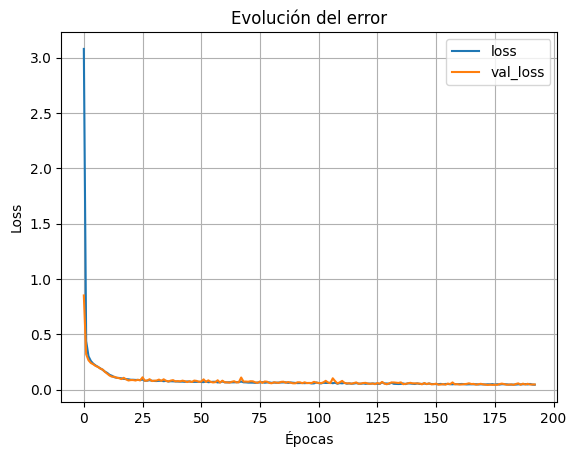

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0432
test_mse: 0.04357260465621948
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


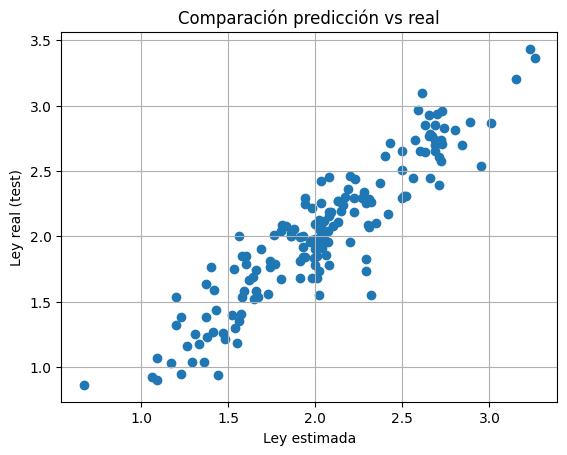

   6/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step 

c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\nicoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step


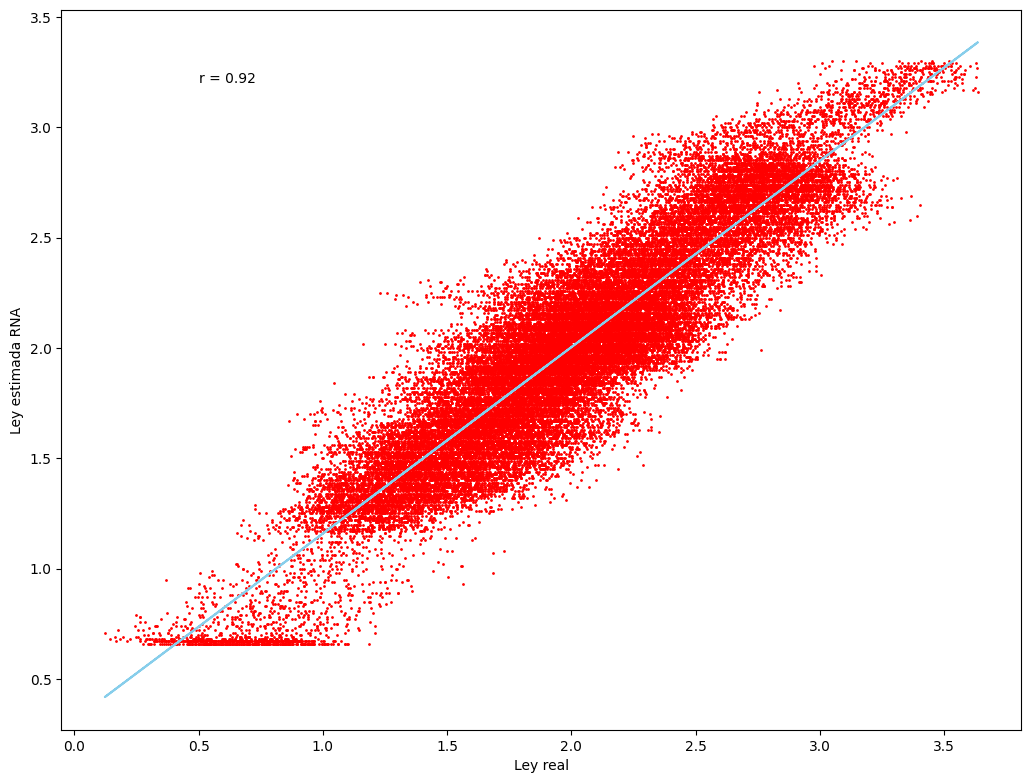

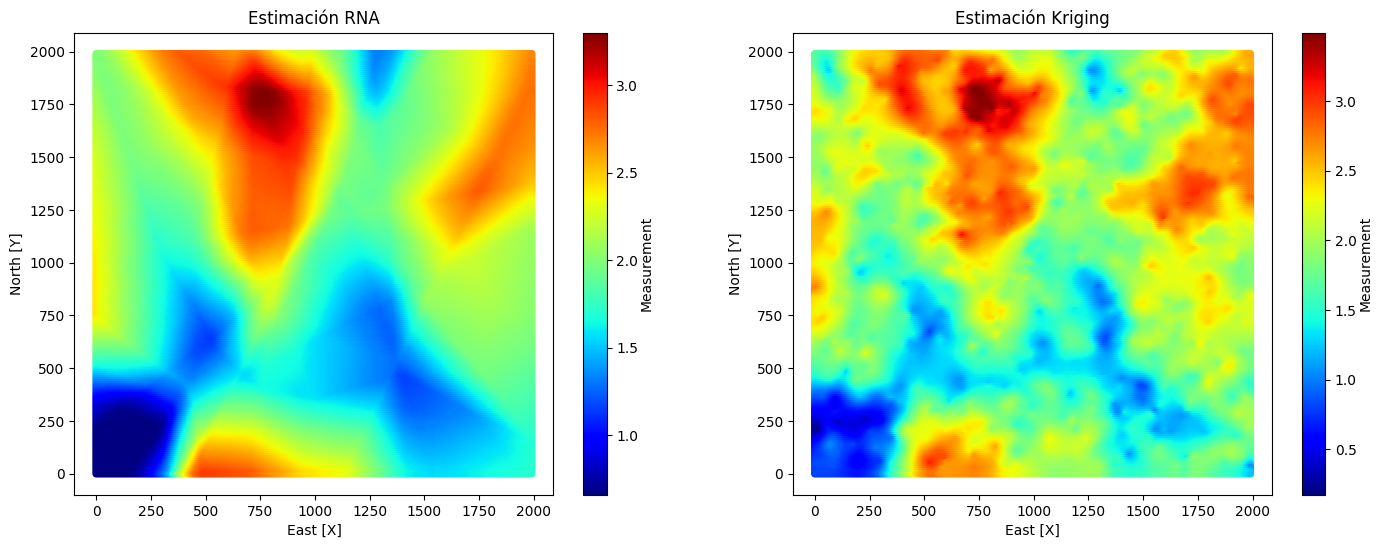

In [156]:
# --- Evaluación del modelo ---
model_loss = pd.DataFrame(history.history)
model_loss.plot()
plt.title("Evolución del error")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

test_loss = network.evaluate(X_test_scaled, y_test)
print('test_mse:', test_loss)

y_pred = network.predict(X_test_scaled).round(2)

plt.scatter(y_pred, y_test)
plt.xlabel("Ley estimada")
plt.ylabel("Ley real (test)")
plt.title("Comparación predicción vs real")
plt.grid(True)
plt.show()

# --- Predicción para malla de bloques ---
df_malla = pd.DataFrame()
df_malla["X"] = df["Este[X]"]
df_malla["Y"] = df["Norte[Y]"]

df_malla_scaled = scaler.transform(df_malla)
df_malla = pd.DataFrame(df_malla_scaled, columns=["X", "Y"])

y_pred_malla = network.predict(df_malla).round(2)
df["VA_RNA"] = y_pred_malla
df.head()

# --- Gráfico de dispersión VA vs VA_RNA ---
x = df["VA"]
y = df["VA_RNA"]
a, b = np.polyfit(x, y, 1)
r = np.corrcoef(x, y)

plt.subplot(111)
plt.scatter(x, y, color="r", s=1)
plt.xlabel("Ley real")
plt.ylabel("Ley estimada RNA")
plt.plot(x, a * x + b, color="skyblue")
plt.text(0.5, 3.2, 'r = {0:2.2f}'.format(r[0, 1]))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5)
plt.show()

# --- Mapa estimaciones ---
fig = plt.figure(figsize=(17, 6))
marker_size = 20

plt.subplot(121)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA_RNA"], cmap=plt.cm.jet)
plt.title("Estimación RNA")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar = plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)

plt.subplot(122)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA_KO"], cmap=plt.cm.jet)
plt.title("Estimación Kriging")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar = plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)

plt.show()

Se puede ver como la estimacion de kriging es super precisa debido a que le pasamos la variografia real con la que se creo el mapa y no usa un mapa variografico estimado de la forma tradicional (es la principal fuente de incertidumbre en la geoestadistica clasica). En cuanto a las rna, se ve una correlacion del 92% y en el mapa se puede corroborar que detecta los patrones como aspecto positivo, pero que al mismo tiempo suaviza los contornos como algo negativo

In [ ]:
# --- Definición del modelo ---
network = models.Sequential()
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(1))  # Salida

network.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.0015)
)

network.summary()

# --- Callback para detener el entrenamiento si no mejora ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# --- Entrenamiento con datos escalados ---
history = network.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)


